## 라이브러리 삽입

In [141]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
import sys
import gc
import pickle
from itertools import product
import os

from xgboost import XGBRegressor
from xgboost import plot_importance

In [142]:
test = pd.read_csv(os.getenv('HOME')+'/add_project/test.csv')
train = pd.read_csv(os.getenv('HOME')+'/add_project/sales_train.csv')
shops = pd.read_csv(os.getenv('HOME')+'/add_project/shops.csv')
items = pd.read_csv(os.getenv('HOME')+'/add_project/items.csv')
cats = pd.read_csv(os.getenv('HOME')+'/add_project/item_categories.csv')

In [143]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


## 이상치 제거

<AxesSubplot:xlabel='item_price'>

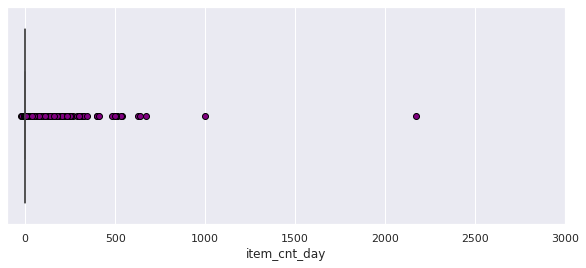

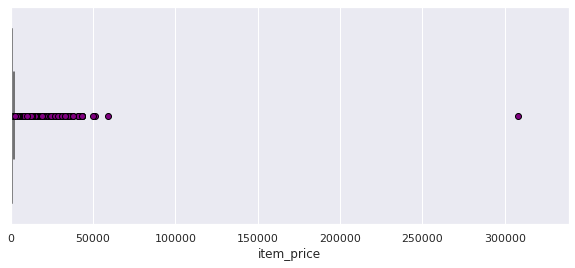

In [144]:
# 출처: Future Sales3
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
flierprops = dict(marker='o', markerfacecolor='purple', markersize=6,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(x=train.item_cnt_day, flierprops=flierprops)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price, flierprops=flierprops)

In [145]:
# 판매량과 가격의 이상치를 제거해 준다.
train = train[(train.item_price < 300000 )& (train.item_cnt_day < 1000)]

<AxesSubplot:xlabel='shop_id', ylabel='count'>

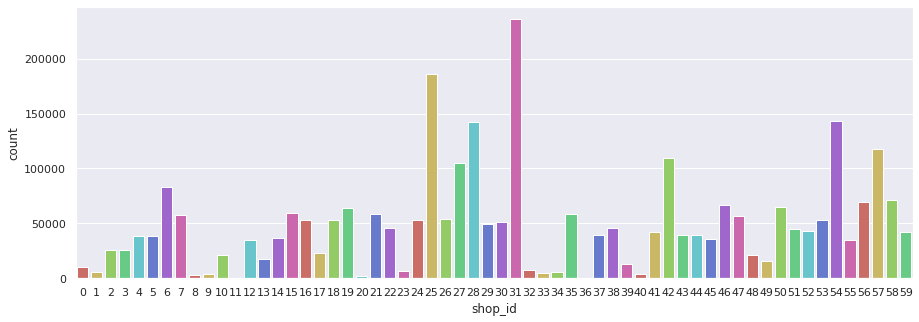

In [146]:
color = sns.color_palette("hls", 8)
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
sns.countplot(x=train['shop_id'], data=train, palette=color)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


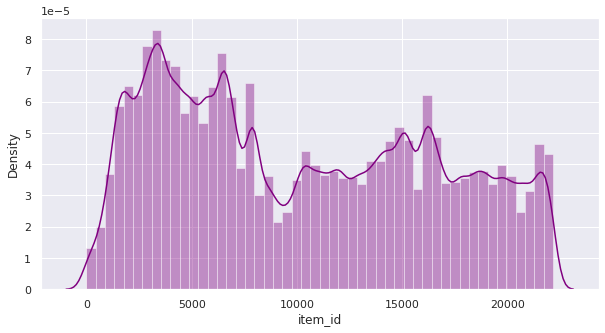

In [155]:
plt.figure(figsize=(10, 5))
sns.distplot(train['item_id'], color="purple");

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


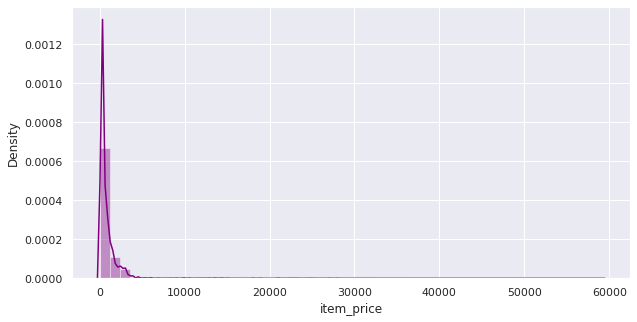

In [154]:
plt.figure(figsize=(10, 5))
sns.distplot(train['item_price'], color="purple");

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


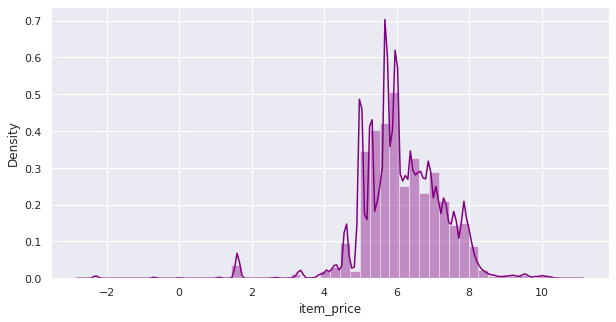

In [153]:
plt.figure(figsize=(10, 5))
sns.distplot(np.log(train['item_price']), color="purple");

## shop 데이터 정리

In [103]:
# shops 이름 정리
shops.loc[ shops.shop_name == 'Сергиев Посад ТЦ "7Я"',"shop_name" ] = 'СергиевПосад ТЦ "7Я"'
shops["city"] = shops.shop_name.str.split(" ").map( lambda x: x[0] )
shops.loc[shops.city == "!Якутск", "city"] = "Якутск"

In [104]:
# shop city column 추가
from sklearn.preprocessing import LabelEncoder
shops["shop_city"] = LabelEncoder().fit_transform( shops.city )
shops = shops[["shop_name", "shop_id", "shop_city"]]

## item category 데이터 정리

In [105]:

cats["main_cat_id"] = cats.item_category_name.str.split("-").map( lambda x: x[0] )
cats["main_cat_id"] = LabelEncoder().fit_transform( cats.main_cat_id )
cats = cats[["item_category_name", "item_category_id", "main_cat_id"]]

In [106]:
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# РостовНаДону ТРК "Мегацентр Горизонт"
train.loc[train.shop_id == 40, 'shop_id'] = 39
test.loc[test.shop_id == 40, 'shop_id'] = 39
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [107]:
cats[0:20]

,item_category_name,item_category_id,main_cat_id
0,PC - Гарнитуры/Наушники,0,0
1,Аксессуары - PS2,1,1
2,Аксессуары - PS3,2,1
3,Аксессуары - PS4,3,1
4,Аксессуары - PSP,4,1
5,Аксессуары - PSVita,5,1
6,Аксессуары - XBOX 360,6,1
7,Аксессуары - XBOX ONE,7,1
8,Билеты (Цифра),8,2
9,Доставка товара,9,3


In [108]:
items

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40
...,...,...,...
22165,"Ядерный титбит 2 [PC, Цифровая версия]",22165,31
22166,Язык запросов 1С:Предприятия [Цифровая версия],22166,54
22167,Язык запросов 1С:Предприятия 8 (+CD). Хрустале...,22167,49
22168,Яйцо для Little Inu,22168,62


In [109]:
items = pd.merge(items, cats, on='item_category_id', how='left')

In [110]:
items=items.drop('item_category_name',axis=1)

In [111]:
items=items.drop('item_name',axis=1)

In [112]:
items

,item_id,item_category_id,main_cat_id
0,0,40,11
1,1,76,15
2,2,40,11
3,3,40,11
4,4,40,11
...,...,...,...
22165,22165,31,8
22166,22166,54,12
22167,22167,49,12
22168,22168,62,14


In [113]:
train=pd.merge(train,items, on ='item_id', how ='left')

In [114]:
train

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id,main_cat_id
0,02.01.2013,0,59,22154,999.00,1.0,37,11
1,03.01.2013,0,25,2552,899.00,1.0,58,13
2,05.01.2013,0,25,2552,899.00,-1.0,58,13
3,06.01.2013,0,25,2554,1709.05,1.0,58,13
4,15.01.2013,0,25,2555,1099.00,1.0,56,13
...,...,...,...,...,...,...,...,...
2935841,10.10.2015,33,25,7409,299.00,1.0,55,13
2935842,09.10.2015,33,25,7460,299.00,1.0,55,13
2935843,14.10.2015,33,25,7459,349.00,1.0,55,13
2935844,22.10.2015,33,25,7440,299.00,1.0,57,13


In [115]:
# https://www.kaggle.com/uladzimirkapeika/feature-engineering-lightgbm-top-1
# Feature engineering, LightGBM - Top 1%
train = train.groupby(['date_block_num','shop_id','item_id','item_category_id','main_cat_id']).agg({'item_cnt_day': ['sum']})
train.columns = ['item_cnt_month']
train.reset_index(inplace=True)

In [116]:
train

,date_block_num,shop_id,item_id,item_category_id,main_cat_id,item_cnt_month
0,0,2,27,19,5,1.0
1,0,2,33,37,11,1.0
2,0,2,317,45,12,1.0
3,0,2,438,45,12,1.0
4,0,2,471,49,12,2.0
...,...,...,...,...,...,...
1608265,33,59,22087,83,20,6.0
1608266,33,59,22088,83,20,2.0
1608267,33,59,22091,83,20,1.0
1608268,33,59,22100,42,12,1.0


In [117]:
train['item_cnt_month'] = (train['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))

In [118]:
train

,date_block_num,shop_id,item_id,item_category_id,main_cat_id,item_cnt_month
0,0,2,27,19,5,1.0
1,0,2,33,37,11,1.0
2,0,2,317,45,12,1.0
3,0,2,438,45,12,1.0
4,0,2,471,49,12,2.0
...,...,...,...,...,...,...
1608265,33,59,22087,83,20,6.0
1608266,33,59,22088,83,20,2.0
1608267,33,59,22091,83,20,1.0
1608268,33,59,22100,42,12,1.0


In [119]:
from itertools import product
import time
ts = time.time()
matrix = []
cols  = ["date_block_num", "shop_id", "item_id"]
for i in range(34):
    sales = train[train.date_block_num == i]
    matrix.append( np.array(list( product( [i], sales.shop_id.unique(), sales.item_id.unique() ) ), dtype = np.int16) )

matrix = pd.DataFrame( np.vstack(matrix), columns = cols )
matrix["date_block_num"] = matrix["date_block_num"].astype(np.int8)
matrix["shop_id"] = matrix["shop_id"].astype(np.int8)
matrix["item_id"] = matrix["item_id"].astype(np.int16)
matrix.sort_values( cols, inplace = True )
time.time()- ts

12.823335647583008

In [121]:
ts = time.time()
group = train.groupby( ["date_block_num", "shop_id", "item_id"] ).agg( {"item_cnt_month": ["sum"]} )
group.columns = ["item_cnt_month"]
group.reset_index( inplace = True)
matrix = pd.merge( matrix, group, on = cols, how = "left" )
matrix["item_cnt_month"] = matrix["item_cnt_month"].fillna(0).astype(np.float16)
time.time() - ts

2.7442660331726074

In [122]:
test["date_block_num"] = 34
test["date_block_num"] = test["date_block_num"].astype(np.int8)
test["shop_id"] = test.shop_id.astype(np.int8)
test["item_id"] = test.item_id.astype(np.int16)

In [123]:
ts = time.time()

matrix = pd.concat([matrix, test.drop(["ID"],axis = 1)], ignore_index=True, sort=False, keys=cols)
matrix.fillna( 0, inplace = True )
time.time() - ts

0.05263113975524902

In [124]:
def lag_feature( df,lags, cols ):
    for col in cols:
        print(col)
        tmp = df[["date_block_num", "shop_id","item_id",col ]]
        for i in lags:
            shifted = tmp.copy()
            shifted.columns = ["date_block_num", "shop_id", "item_id", col + "_lag_"+str(i)]
            shifted.date_block_num = shifted.date_block_num + i
            df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df

In [125]:
ts = time.time()
matrix = lag_feature( matrix, [1,2,3], ["item_cnt_month"] )
time.time() - ts

item_cnt_month


13.758373737335205

In [126]:
ts = time.time()
group = matrix.groupby( ["date_block_num"] ).agg({"item_cnt_month" : ["mean"]})
group.columns = ["date_avg_item_cnt"]
group.reset_index(inplace = True)

matrix = pd.merge(matrix, group, on = ["date_block_num"], how = "left")
matrix.date_avg_item_cnt = matrix["date_avg_item_cnt"].astype(np.float16)
matrix = lag_feature( matrix, [1], ["date_avg_item_cnt"] )
matrix.drop( ["date_avg_item_cnt"], axis = 1, inplace = True )
time.time() - ts

date_avg_item_cnt


6.0063276290893555

In [127]:
matrix["month"] = matrix["date_block_num"] % 12
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix["days"] = matrix["month"].map(days).astype(np.int8)

In [128]:
import gc
import pickle
from xgboost import XGBRegressor
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

In [129]:
data = matrix.copy()
del matrix
gc.collect()

5702

In [130]:
data[data["date_block_num"]==34].shape

(214200, 10)

In [131]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [132]:
Y_train = Y_train.clip(0, 20)
Y_valid = Y_valid.clip(0, 20)

In [133]:
del data
gc.collect();

In [134]:
ts = time.time()

model = XGBRegressor(
    max_depth=10,
    n_estimators=1000,
    min_child_weight=0.5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.1,
#     tree_method='gpu_hist',
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 20)

time.time() - ts

[0]	validation_0-rmse:1.21382	validation_1-rmse:1.13622
[1]	validation_0-rmse:1.18700	validation_1-rmse:1.11465
[2]	validation_0-rmse:1.14741	validation_1-rmse:1.08455
[3]	validation_0-rmse:1.11613	validation_1-rmse:1.06055
[4]	validation_0-rmse:1.08937	validation_1-rmse:1.04199
[5]	validation_0-rmse:1.06508	validation_1-rmse:1.02567
[6]	validation_0-rmse:1.04657	validation_1-rmse:1.01252
[7]	validation_0-rmse:1.03191	validation_1-rmse:1.00215
[8]	validation_0-rmse:1.02423	validation_1-rmse:0.99609
[9]	validation_0-rmse:1.01242	validation_1-rmse:0.98869
[10]	validation_0-rmse:1.00147	validation_1-rmse:0.98308
[11]	validation_0-rmse:0.99316	validation_1-rmse:0.97909
[12]	validation_0-rmse:0.98582	validation_1-rmse:0.97519
[13]	validation_0-rmse:0.97867	validation_1-rmse:0.97245
[14]	validation_0-rmse:0.97309	validation_1-rmse:0.97063
[15]	validation_0-rmse:0.97011	validation_1-rmse:0.96875
[16]	validation_0-rmse:0.96604	validation_1-rmse:0.96747
[17]	validation_0-rmse:0.96387	validation

269.3731572628021

In [135]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)